### 1.2 신경망의 추론
#### 1.2.1 신경망 추론 전체 그림

In [1]:
import numpy as np

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

x = np.random.randn(10, 2) # 입력
W1 = np.random.randn(2, 4) # 가중치
b1 = np.random.randn(4)    # 편향
W2 = np.random.randn(4, 3)
b2 = np.random.randn(3)

h = np.matmul(x, W1) +  b1
a = sigmoid(h)
s = np.matmul(a, W2) + b2

#### 1.2.2 계층으로 클래스화 및 순전파 구현
모듈화를 통해 신경망을 구축해보자. 다음 구현 규칙을 가지는 클래스를 만들자.
* 모든 계층은 `forward()`와 `backward()` 메서드를 가진다.
* 모든 계층은 인스턴스 변수인 `params`와 `grads`를 가진다.  
-> `forward()`와 `backward()`는 각각 순전파, 역전파를 의미하고,  
`grads`는 `params`에 저장된 각 매개변수에 대응하여 해당 매개변수의 기울기를 보관하는 리스트이다.

In [9]:
class Sigmoid:
    def __init__(self):
        self.params = []
        
    def forward(self, x):
        return 1 / (1 + np.exp(-x))
    
class Affine:
    def __init__(self, W, b):
        self.params = [W, b]
        
    def forward(self, x):
        W, b = self.params
        out = np.matmul(x, W) + b
        return out

In [14]:
class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size):
        I, H, O = input_size, hidden_size, output_size
        
        # 가중치와 편향 초기화
        W1 = np.random.randn(I, H)
        b1 = np.random.randn(H)
        W2 = np.random.randn(H, O)
        b2 = np.random.randn(O)
        
        # 계층 생성
        self.layers = [
            Affine(W1, b1),
            Sigmoid(),
            Affine(W2, b2)
        ]
        
        # 모든 가중치를 리스트에 모은다.
        self.params = []
        for layer in self.layers:
            self.params += layer.params
            
    def predict(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

In [15]:
x = np.random.randn(10, 2)
model = TwoLayerNet(2, 4, 3)
s = model.predict(x)
print(s)

[[ 3.09791651 -0.73924743  0.86570786]
 [ 3.73719873 -0.1282783   1.11797607]
 [ 3.37007981 -0.45637231  0.47660684]
 [ 3.61720696 -0.21975963  0.97398052]
 [ 3.59430932 -0.33326984  0.2195894 ]
 [ 3.68638811 -0.24082458  1.26645088]
 [ 3.39762937 -0.43573645  1.01761019]
 [ 3.62928133 -0.25401453  1.19495751]
 [ 3.76382074 -0.28568211 -0.13801393]
 [ 3.69378386 -0.31062828 -0.02107396]]


### 1.3 신경망의 학습

In [16]:
class MatMul:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_lile(W)]
        self.x = None
    
    def forward(self, x):
        W, = self.params
        out = np.matmul(x, W)
        self.x = x
        return out
    
    def backward(self, dout):
        W, = self.params
        dx = np.matmul(dout, W.T)
        dW = np.matmul(self.x.T, dout)
        self.grads[0][...] = dW       # grads에 dW를 깊은 복사
        return dx

In [17]:
class Sigmoid:
    def __init__(self):
        self.params, self.grads = [], []
        self.out = None
        
    def forward(self, x):
        out = 1 / (1 + np.exp(-x))
        self.out = out
        return out
    
    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out
        return dx

In [18]:
class Affine:
    def __init__(self, W, b):
        self.params = [W, b]
        self.grads = [np.zeros_like(W), np.zeros_like(b)]
        self.x = None
    
    def forward(self, x):
        W, b = self.params
        out = np.matmul(x, W) + b
        self.x = x
        return out
    
    def backward(self, dout):
        W, b = self.params
        dx = np.matmul(dout, W.T)
        dW = np.matmul(self.x.T, dout)
        db = np.sum(dout, axis=0)
        
        self.grad[0][...] = dW
        self.grad[1][...] = db
        return dx

In [1]:
def softmax(a):
    c = np.max(a)
    exp_a = np.exp(a - c) # 오버플로 대책
    sum_exp_a = np.sum(exp_a)
    y = exp_a / sum_exp_a
    
    return y

def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    batch_size = y.shape[0]
    return -np.sum(t * np.log(y)) / batch_size
    
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None # 손실
        self.y = None    # softmax의 출력
        self.t = None    # 정답 레이블(원-핫 벡터)    
        
    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        return self.loss
    
    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        dx = (self.y - self.t) / batch_size
        
        return dx
        

#### 가중치 갱신
* 1단계: 미니배치  
훈련 데이터 중에서 무작위로 다수의 데이터를 골라낸다.  
* 2단계: 기울기 계산  
오차역전파법으로 각 가중치 매개변수에 대한 손실 함수의 기울기를 구한다.
* 3단계: 매개변수 갱신  
기울기를 사용하여 가중치 매개변수를 갱신한다.
* 4단계: 반복  
1~3단계를 필요한 만큼 반복한다.

In [2]:
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr
        
    def update(self, params, grads):
        for i in range(len(params)):
            params[i] -= self.lr + grads[i]

In [ ]:
# Exercise (psuedo-code)
model = TwoLayerNet(...)

for i in range(10000):
    ...
    x_batch, t_batch = get_mini_batch(...) # 미니배치 획득
    loss = model.forward(x_batch, t_batch)
    model.backward()
    optimizer.update(model.params, model.grads)
    ...

### 1.4 신경망으로 문제를 풀다

In [3]:
import sys
sys.path.append('..')
from dataset import spiral
import matplotlib.pyplot as plt

x, t = spiral.load_data()
print('x', x.shape) # (300, 2)
print('t', t.shape) # (300, 3)

x (300, 2)
t (300, 3)


In [11]:
import sys
sys.path.append('..')
import numpy as np
from common.layers import Affine, Sigmoid, SoftmaxWithLoss

class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size):
        I, H, O = input_size, hidden_size, output_size
        
        # 가중치의 편향 초기화
        W1 = 0.01 * np.random.randn(I, H)
        b1 = np.zeros(H)
        W2 = 0.01 * np.random.randn(H, O)
        b2 = np.zeros(O)
        
        # 계층 생성
        self.layers = [
            Affine(W1, b1),
            Sigmoid(),
            Affine(W2, b2)
        ]
        self.loss_layer = SoftmaxWithLoss()
        
        # 모든 가중치와 기울기를 리스트에 모은다.
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads
            
    def predict(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x
    
    def forward(self, x, t):
        score = self.predict(x)
        loss = self.loss_layer.forward(score, t)
        return loss
    
    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

In [12]:
import sys
sys.path.append('..')
import numpy as np
from common.optimizer import SGD
from dataset import spiral
import matplotlib.pyplot as plt

# 하이퍼파라미터 설정
max_epoch = 300
batch_size = 30
hidden_size = 10
learning_rate = 1.0

# 데이터 읽기, 모델과 옵티마이저 생성
x, t = spiral.load_data()
model = TwoLayerNet(input_size=2, hidden_size=hidden_size, output_size=3)
optimizer = SGD(lr=learning_rate)

# 학습에 사용하는 변수
data_size = len(x)
max_iters = data_size // batch_size
total_loss = 0
loss_count = 0
loss_list = []

for epoch in range(max_epoch):
    # 데이터 뒤섞기
    idx = np.random.permutation(data_size)
    x = x[idx]
    t = t[idx]
    
    for iters in range(max_iters):
        batch_x = x[iters*batch_size:(iters+1)*batch_size]
        batch_t = t[iters*batch_size:(iters+1)*batch_size]
        
        # 기울기를 구해 매개변수 갱신
        loss = model.forward(batch_x, batch_t)
        model.backward()
        optimizer.update(model.params, model.grads)
        
        total_loss += loss
        loss_count += 1
        
        # 정기적으로 학습 경과 출력
        if (iters+1) % 10 == 0:
            avg_loss = total_loss / loss_count
            print('| 에폭 %d | 반복 %d / %d | 손실 %.2f'
                 % (epoch + 1, iters + 1, max_iters, avg_loss))
            loss_list.append(avg_loss)
            total_loss, loss_count = 0, 0

| 에폭 1 | 반복 10 / 10 | 손실 1.13
| 에폭 2 | 반복 10 / 10 | 손실 1.13
| 에폭 3 | 반복 10 / 10 | 손실 1.12
| 에폭 4 | 반복 10 / 10 | 손실 1.12
| 에폭 5 | 반복 10 / 10 | 손실 1.11
| 에폭 6 | 반복 10 / 10 | 손실 1.14
| 에폭 7 | 반복 10 / 10 | 손실 1.16
| 에폭 8 | 반복 10 / 10 | 손실 1.11
| 에폭 9 | 반복 10 / 10 | 손실 1.12
| 에폭 10 | 반복 10 / 10 | 손실 1.13
| 에폭 11 | 반복 10 / 10 | 손실 1.12
| 에폭 12 | 반복 10 / 10 | 손실 1.11
| 에폭 13 | 반복 10 / 10 | 손실 1.09
| 에폭 14 | 반복 10 / 10 | 손실 1.08
| 에폭 15 | 반복 10 / 10 | 손실 1.04
| 에폭 16 | 반복 10 / 10 | 손실 1.03
| 에폭 17 | 반복 10 / 10 | 손실 0.96
| 에폭 18 | 반복 10 / 10 | 손실 0.92
| 에폭 19 | 반복 10 / 10 | 손실 0.92
| 에폭 20 | 반복 10 / 10 | 손실 0.87
| 에폭 21 | 반복 10 / 10 | 손실 0.85
| 에폭 22 | 반복 10 / 10 | 손실 0.82
| 에폭 23 | 반복 10 / 10 | 손실 0.79
| 에폭 24 | 반복 10 / 10 | 손실 0.78
| 에폭 25 | 반복 10 / 10 | 손실 0.82
| 에폭 26 | 반복 10 / 10 | 손실 0.78
| 에폭 27 | 반복 10 / 10 | 손실 0.76
| 에폭 28 | 반복 10 / 10 | 손실 0.76
| 에폭 29 | 반복 10 / 10 | 손실 0.78
| 에폭 30 | 반복 10 / 10 | 손실 0.75
| 에폭 31 | 반복 10 / 10 | 손실 0.78
| 에폭 32 | 반복 10 / 10 | 손실 0.77
| 에폭 33 | 반복 10 /

#### With Trainer Class

| 에폭 1 |  반복 1 / 10 | 시간 0[s] | 손실 1.10
| 에폭 2 |  반복 1 / 10 | 시간 0[s] | 손실 1.12
| 에폭 3 |  반복 1 / 10 | 시간 0[s] | 손실 1.13
| 에폭 4 |  반복 1 / 10 | 시간 0[s] | 손실 1.12
| 에폭 5 |  반복 1 / 10 | 시간 0[s] | 손실 1.12
| 에폭 6 |  반복 1 / 10 | 시간 0[s] | 손실 1.10
| 에폭 7 |  반복 1 / 10 | 시간 0[s] | 손실 1.14
| 에폭 8 |  반복 1 / 10 | 시간 0[s] | 손실 1.16
| 에폭 9 |  반복 1 / 10 | 시간 0[s] | 손실 1.11
| 에폭 10 |  반복 1 / 10 | 시간 0[s] | 손실 1.12
| 에폭 11 |  반복 1 / 10 | 시간 0[s] | 손실 1.12
| 에폭 12 |  반복 1 / 10 | 시간 0[s] | 손실 1.12
| 에폭 13 |  반복 1 / 10 | 시간 0[s] | 손실 1.10
| 에폭 14 |  반복 1 / 10 | 시간 0[s] | 손실 1.09
| 에폭 15 |  반복 1 / 10 | 시간 0[s] | 손실 1.08
| 에폭 16 |  반복 1 / 10 | 시간 0[s] | 손실 1.04
| 에폭 17 |  반복 1 / 10 | 시간 0[s] | 손실 1.03
| 에폭 18 |  반복 1 / 10 | 시간 0[s] | 손실 0.94
| 에폭 19 |  반복 1 / 10 | 시간 0[s] | 손실 0.92
| 에폭 20 |  반복 1 / 10 | 시간 0[s] | 손실 0.92
| 에폭 21 |  반복 1 / 10 | 시간 0[s] | 손실 0.87
| 에폭 22 |  반복 1 / 10 | 시간 0[s] | 손실 0.85
| 에폭 23 |  반복 1 / 10 | 시간 0[s] | 손실 0.80
| 에폭 24 |  반복 1 / 10 | 시간 0[s] | 손실 0.79
| 에폭 25 |  반복 1 / 10 | 시간

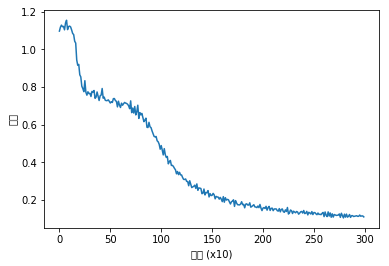

In [17]:
import sys
sys.path.append('..')
from common.optimizer import SGD
from common.trainer import Trainer
from dataset import spiral

max_epoch = 300
batch_size = 30
hidden_size = 10
learning_rate = 1.0

x, t = spiral.load_data()
model = TwoLayerNet(input_size=2, hidden_size=hidden_size, output_size=3)
optimizer = SGD(lr=learning_rate)

trainer = Trainer(model, optimizer)
trainer.fit(x, t, max_epoch, batch_size, eval_interval=10)
trainer.plot()